# Languages of India

I was just curious about what languages were spoken in which regions of india.

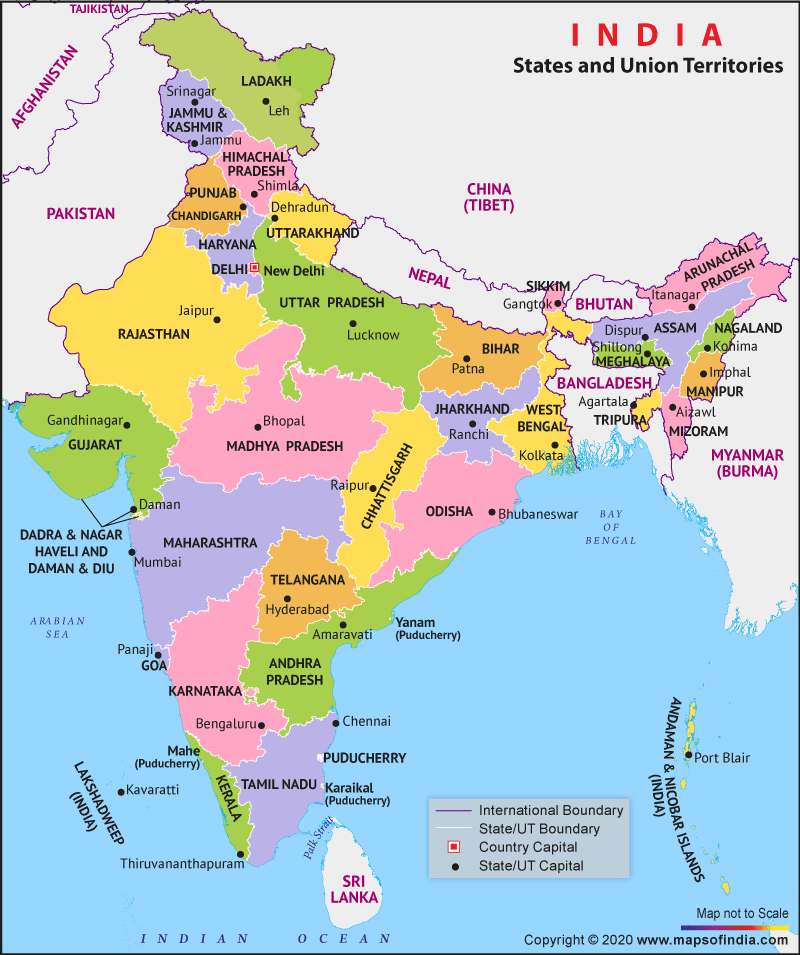

In [47]:
from IPython.display import Image
# from https://www.mapsofindia.com/maps/india/india-political-map.htm
Image("india-political-map.gif")

The first question I wanted to know is what are the dominent languages of the indian states and provinces. I have taken data from the indian census from 2011

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')
import random
import geopandas as gp

plt.rcParams['figure.figsize'] = 15, 15

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

In [49]:
# from https://censusindia.gov.in/2011census/C-16.html
df_og = pd.read_excel('indianlanguages.xlsx')


I am only interested in the total column at the moment, and so much the genders or whether the person lives in a rural or urban setting. So let us simplify the dataframe a little.
Let's split this up into two dataframes one for the all of india, and the another for all the states and unions.

In [50]:
languages = df_og.iloc[2:,:4]

languages[['Mother tongue code','Total']] = languages[['Mother tongue code', 'Total']].astype(int)

# The mother tongue codes which end in 000 are the parent languages, filter the dataframe by those 
languages = languages[languages['Mother tongue code'].apply(lambda code: code % 1000 == 0)]
# Strip the numbers from the start of the 'Mother tongue name' column
languages['Mother tongue name'] = languages['Mother tongue name'].str.replace('\d+\s','', regex=True)
# drop the Mother tongue code column as it may be confusing because it is missing numbers 99000 & 110000
languages = languages[['Area name', 'Mother tongue name', 'Total']]
# stripping whitespaces in Mother tongue name column
languages['Mother tongue name'] = languages['Mother tongue name'].str.strip()


# languages of india as a whole
lang_of_india = languages[languages['Area name'] == 'INDIA'].reset_index(drop=True)

display(lang_of_india)

# languages of indian states
lang_indian_states = languages[languages['Area name'] != 'INDIA'].reset_index(drop=True)

display(lang_indian_states)

,Area name,Mother tongue name,Total
0,INDIA,ASSAMESE,15311351
1,INDIA,BENGALI,97237669
2,INDIA,BODO,1482929
3,INDIA,DOGRI,2596767
4,INDIA,GUJARATI,55492554
...,...,...,...
117,INDIA,YIMCHUNGRE,83259
118,INDIA,ZELIANG,63529
119,INDIA,ZEMI,50925
120,INDIA,ZOU,26545


,Area name,Mother tongue name,Total
0,JAMMU & KASHMIR,ASSAMESE,8340
1,JAMMU & KASHMIR,BENGALI,19830
2,JAMMU & KASHMIR,BODO,508
3,JAMMU & KASHMIR,DOGRI,2513712
4,JAMMU & KASHMIR,GUJARATI,19261
...,...,...,...
3111,ANDAMAN & NICOBAR ISLANDS,TRIPURI,26
3112,ANDAMAN & NICOBAR ISLANDS,VAIPHEI,5
3113,ANDAMAN & NICOBAR ISLANDS,ZEMI,2
3114,ANDAMAN & NICOBAR ISLANDS,ZOU,2


Before we get into the whole graphing side of things I wanted create a color palette where each languages is assigned to a particular color. This will make the differences in the popularity of languages more apparent. 

In [51]:
values = sns.color_palette("husl", n_colors=122)
keys = list(lang_of_india['Mother tongue name'].unique()) 

# because there are so many languages I wanted to shuffle the color values 
# so not too many similar colours are next to each other 
random.seed(3)
random.shuffle(values)

color_dict = dict(zip(keys, values))

## languages of India as a whole

Here we will analyse the languages of india as a whole.

Just before we create some bar graphs I just wanted to check if the populations match up if I sum the Total column

In [52]:
display('Sum of the Total column: ' + str(sum(lang_of_india['Total'])))
display('Number of languages: ' + str(len(lang_of_india) - 1) + " (Not including the last entry which is just 'OTHER' languages)")

'Sum of the Total column: 1210854977'

"Number of languages: 121 (Not including the last entry which is just 'OTHER' languages)"

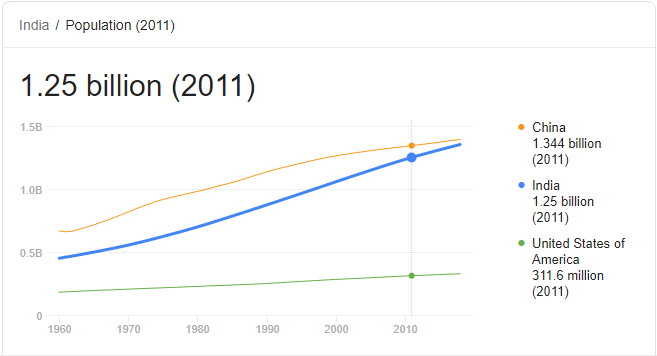

In [53]:
# comparing the census data to a google search 
Image('GoogleSearchIndPop2011.PNG')

We have about 40 million people unaccounted for in this data. This could be because some people did not partake in the census.

Now lets create a bar graph. Since there is 121 languages, I will just graph the top 20.

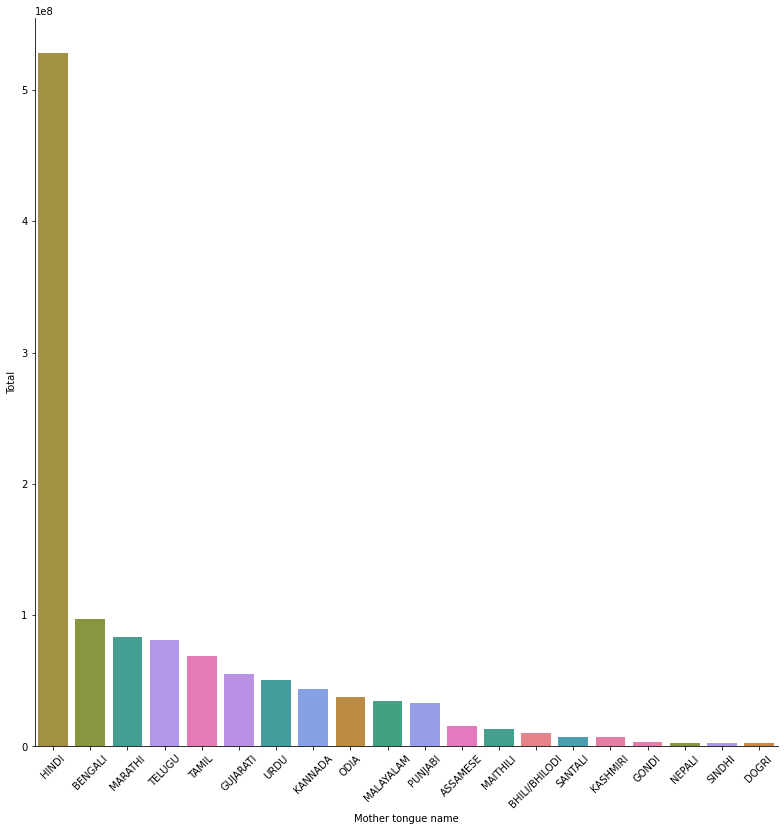

In [54]:
sns.catplot(kind='bar', 
            data=lang_of_india.nlargest(20, 'Total'), 
            x='Mother tongue name', 
            y='Total', 
            height=11,
            palette=color_dict
           )
plt.xticks(rotation=45)
plt.show()

## India by region
There a 35 states/unions as of 2011 when the census took place.

create a pallette dictionary to map each language to a color.
https://stackoverflow.com/questions/46173419/seaborn-change-bar-colour-according-to-hue-name

In [55]:
len(lang_indian_states['Area name'].unique())

35

In [56]:
region_options = list(lang_indian_states['Area name'].unique())

menu = widgets.Dropdown(
    options=region_options,
    value='GOA',
    description='Area name:',
    disabled=False,
)

def lang_region(region):
    region_df = lang_indian_states[lang_indian_states['Area name'] == region].nlargest(15, 'Total')
    sns.catplot(kind='bar', 
            data=region_df, 
            x='Mother tongue name', 
            y='Total', 
            height=11,
            palette=color_dict
           )
    plt.title(region)
    plt.xticks(rotation=45)
    plt.show()

widgets.interact(lang_region, region=menu)


interactive(children=(Dropdown(description='Area name:', index=29, options=('JAMMU & KASHMIR', 'HIMACHAL PRADE…

<function __main__.lang_region(region)>

#### Analysis



## Heat map of popularity of all languages

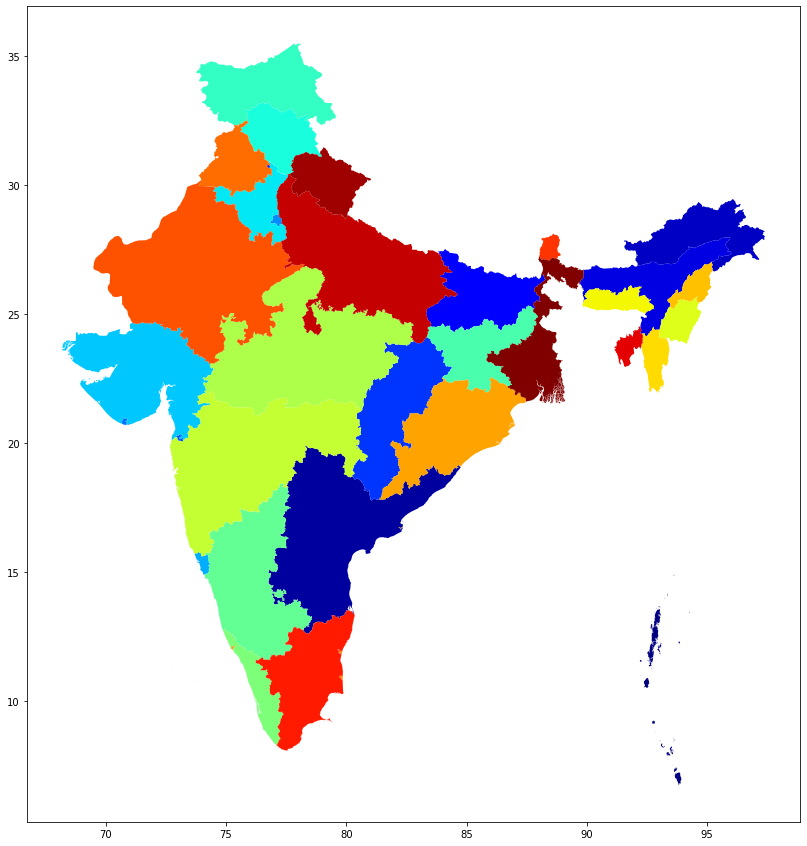

In [57]:
india_map = gp.read_file(r'C:\Users\harpo\Documents\Data Science Work\projects in progress\Languages of India\states\IND_adm1.shp')

india_map.plot(cmap='jet', figsize=(15,15))
plt.show()


In [58]:
# Clean up useless columns in india_map dataframe
clean_map = india_map[['NAME_1', 'ENGTYPE_1', 'Shape_Leng', 'Shape_Area', 'geometry']]

# finding out the total number of people in each area
tot_per_area = lang_indian_states.groupby('Area name', as_index=False)[['Total']].sum()

# making sure the area names in both dataframes match
clean_map.rename(columns={'NAME_1':'Area name', 'ENGTYPE_1':'Territory type'}, inplace=True)

clean_map['Area name'] = clean_map['Area name'].str.upper()
clean_map['Area name'] = clean_map['Area name'].str.replace(' AND ', ' & ')

# inconsistent Area names in clean_map were replaced with the corresponding names from the census data
# UTTARAKHAND (formally know as UTTARANCHAL) & ODISHA (formally known as ORISSA) had to be changed
clean_to_censusDict = {'ANDAMAN & NICOBAR': 'ANDAMAN & NICOBAR ISLANDS',  
                       'DELHI': 'NCT OF DELHI',
                      'ORISSA': 'ODISHA',
                      'UTTARANCHAL': 'UTTARAKHAND'}

clean_map['Area name'] = clean_map.replace({'Area name' : clean_to_censusDict})

# Mergeing the two dataframes
clean_map_tot = pd.merge(clean_map, tot_per_area, on='Area name')

#display(clean_map_tot.head())

,Area name,Territory type,Shape_Leng,Shape_Area,geometry,Total
0,ANDAMAN & NICOBAR ISLANDS,Union Territory,33.514047,0.630484,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8...",380581
1,ANDHRA PRADESH,State,58.916311,23.281297,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13...",84580777
2,ARUNACHAL PRADESH,State,24.851991,7.529301,"POLYGON ((96.15778 29.38310, 96.16380 29.37668...",1383727
3,ASSAM,State,28.542964,7.091458,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...",31205576
4,BIHAR,State,25.980049,8.475058,"POLYGON ((84.11342 27.51544, 84.11881 27.51397...",104099452


35

Finding the top three languages in all states, and creating a list of these languages (with no duplicates).

In [59]:
'''
Use a for loop and the names of all the states in lang_ingian_states
to merge them into a single list, and find the unique languages top_languages
'''

def top3(area_name):
    toplangs = lang_indian_states[lang_indian_states['Area name'] == area_name].nlargest(3, 'Total')
    return list(toplangs['Mother tongue name'].values)


all_top_lang = []

for area in list(lang_indian_states['Area name'].unique()):
    all_top_lang.extend(top3(area))

all_top_lang = list(dict.fromkeys(all_top_lang))

#display(all_top_lang)

In [60]:
'''
With a for loop I calculated the percent of spoken language per area of the most popular languages in 
India (all_top_lang list). Using the lang_indian_state df I was able to extend the clean_map_tot df with the percent of 
the population of that state/union spoke a particular language
'''

# Loop through the list of the most popular languages in India 
# Then I extended the clean_map_tot dataframe to contain column everyone of these languages
# lastly I divided the amount people that spoke that language by the population of that state


for lang in all_top_lang:
    temp = lang_indian_states[lang_indian_states['Mother tongue name'] == lang].rename(columns={'Total': lang})
    clean_map_tot = pd.merge(clean_map_tot, temp[['Area name', lang]], on='Area name', how='outer')
    clean_map_tot[lang] = clean_map_tot[lang]/clean_map_tot['Total'] * 100

clean_map_tot.replace(np.nan, 0, inplace=True)
display(clean_map_tot.head())

,Area name,Territory type,Shape_Leng,Shape_Area,geometry,Total,KASHMIRI,HINDI,DOGRI,PUNJABI,...,GONDI,MARATHI,GUJARATI,SINDHI,TELUGU,KANNADA,KONKANI,MALAYALAM,TAMIL,TULU
0,ANDAMAN & NICOBAR ISLANDS,Union Territory,33.514047,0.630484,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8...",380581,0.008934,19.292608,0.017605,0.411213,...,0.001051,0.167901,0.063324,0.003679,13.243961,0.062799,0.026013,7.219225,15.195188,0.000000
1,ANDHRA PRADESH,State,58.916311,23.281297,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13...",84580777,0.000681,3.689270,0.000909,0.028864,...,0.253288,0.797969,0.069692,0.013359,83.550639,0.631519,0.003227,0.072294,0.843984,0.000676
2,ARUNACHAL PRADESH,State,24.851991,7.529301,"POLYGON ((96.15778 29.38310, 96.16380 29.37668...",1383727,0.007805,7.095836,0.071835,0.265515,...,0.003324,0.166001,0.026161,0.000867,0.119460,0.038736,0.003975,0.289942,0.090047,0.000072
3,ASSAM,State,28.542964,7.091458,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...",31205576,0.001144,6.734165,0.005002,0.074708,...,0.018763,0.037304,0.024547,0.062957,0.085337,0.008322,0.001323,0.018484,0.016757,0.000292
4,BIHAR,State,25.980049,8.475058,"POLYGON ((84.11342 27.51544, 84.11881 27.51397...",104099452,0.000947,77.520548,0.000244,0.010055,...,0.000020,0.001897,0.007970,0.002139,0.001409,0.000473,0.000022,0.001172,0.000947,0.000417


In [61]:

select_menu = widgets.Select(
    options=all_top_lang,
    value='HINDI',
    description='Language:',
    disabled=False,
    rows=7
    )

def popularity_plot(language):
    fig, ax = plt.subplots(1, 1)

    clean_map_tot.plot(column=language, 
                       cmap='RdYlGn',
                       ax=ax,
                       legend=True, 
                       legend_kwds={'label': "Popularity in %"},
                       vmax=100,
                       vmin=0,
                       linewidth=0.1,
                       edgecolor='grey')
    plt.title(language)
    plt.show()


widgets.interact(popularity_plot, language=select_menu)

interactive(children=(Select(description='Language:', index=1, options=('KASHMIRI', 'HINDI', 'DOGRI', 'PUNJABI…

<function __main__.popularity_plot(language)>

This heat map shows how widely spoken a language is. It is interesting to see the concentrations of these languages spoken localized to different regions of the country. Even Hindi, the most widely spoken langauge in India, is mainly spoken in the north of India.

Other langauges 